In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

sns.set_style('darkgrid')
sns.set_palette('deep')

In [109]:
gt = pd.read_csv('globalterrorismdb_0718dist.csv', encoding='ISO-8859-1',low_memory=False)

# # We shall briefly examine everything we have with the data set

In [110]:
pd.options.display.max_rows = 500
gt.head()


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [111]:
gt.shape

(181691, 135)

In [112]:
gt.columns

Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related'],
      dtype='object', length=135)

In [113]:
#rename columns for easier use and dropping columns that are not useful for our analysis


gt.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','country_txt':'Country','region_txt':'Region','attacktype1_txt':'AttackType','target1':'Target','nkill':'Killed','nwound':'Wounded','summary':'Summary','gname':'Group','targtype1_txt':'Target_type','weaptype1_txt':'Weapon_type','motive':'Motive'},inplace=True)
gt=gt[['Year','Month','Day','Country','Region','city','latitude','longitude','AttackType','Killed','Wounded','Target','Summary','Group','Target_type','Weapon_type','Motive']]
gt['casualties']=gt['Killed']+gt['Wounded']


In [114]:
#examine coloumns for any data type irregularities
#Locations,attack types,target types etc have a numerical code and a text entry

gt.dtypes

Year             int64
Month            int64
Day              int64
Country         object
Region          object
city            object
latitude       float64
longitude      float64
AttackType      object
Killed         float64
Wounded        float64
Target          object
Summary         object
Group           object
Target_type     object
Weapon_type     object
Motive          object
casualties     float64
dtype: object

In [115]:
#examine for null values
gt.isnull().sum()

Year                0
Month               0
Day                 0
Country             0
Region              0
city              434
latitude         4556
longitude        4557
AttackType          0
Killed          10313
Wounded         16311
Target            636
Summary         66129
Group               0
Target_type         0
Weapon_type         0
Motive         131130
casualties      16874
dtype: int64

In [116]:
#examining some important facts:  
#it will be interesting to visualize these facts later on


print('Country with Lowest Terrorist Attacks:',gt['Country'].value_counts(ascending=True).index[0]) #what country is marked as international?

print('Country with Highest Terrorist Attacks:',gt['Country'].value_counts().index[0])
      
print('Regions with Lowest Terrorist Attacks:',gt['Region'].value_counts(ascending=True).index[0])
      
print('Regions with Highest Terrorist Attacks:',gt['Region'].value_counts().index[0]) #interesting because New Zealand recently had a very deadly terrorist attack
      
print('Maximum people killed in an attack are:',gt['Killed'].max(),'that took place in',gt.loc[gt['Killed'].idxmax()].Country)

Country with Lowest Terrorist Attacks: Falkland Islands
Country with Highest Terrorist Attacks: Iraq
Regions with Lowest Terrorist Attacks: Australasia & Oceania
Regions with Highest Terrorist Attacks: Middle East & North Africa
Maximum people killed in an attack are: 1570.0 that took place in Iraq


## Lets Visualise our data

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000.]),
 <a list of 6 Text xticklabel objects>)

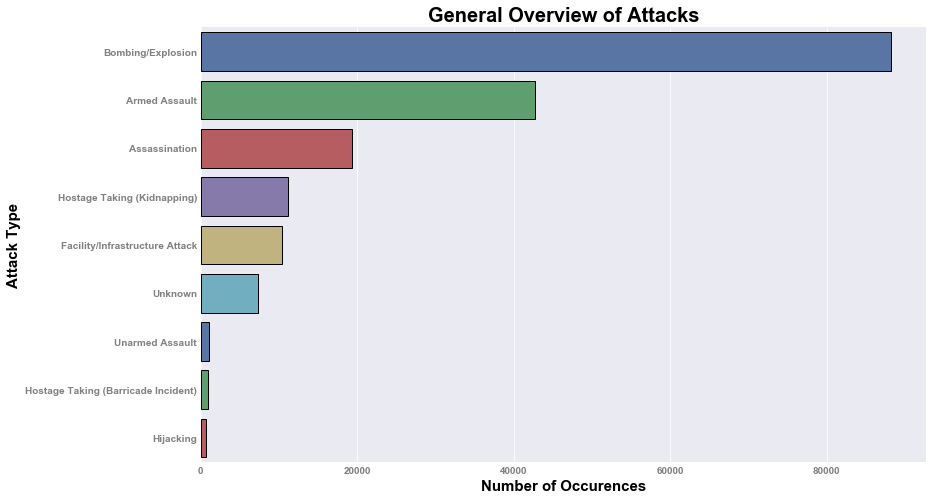

In [117]:

# Overview of attacks


plt.figure(figsize=(13,8))
ax = sns.barplot(x= gt.AttackType.value_counts().values,
                 y= gt.AttackType.value_counts().index,
                 data    = gt,
                 palette = 'deep',edgecolor='black')

ax.set_xlabel('Number of Occurences',fontsize = 15,weight   = 'bold',color = 'black')
ax.set_ylabel('Attack Type',fontsize = 15,weight   = 'bold',color = 'black')

plt.title('General Overview of Attacks',fontsize = 20,weight   = 'extra bold', color    = 'black')
plt.yticks(rotation = 0, weight   = 'bold', fontsize = 10, color   = 'grey')
plt.xticks(weight   = 'bold', fontsize = 10,color = 'grey')


In [123]:
# Lets look at the distribution of attacks yearwise

# No. of attacks for each year:

years_in_database = list(range(1970, 2018))
attacks_per_year = []

for year in years_in_database:
    number_of_attacks = gt.loc[gt.Year == year, :].shape[0]
    attacks_per_year.append(number_of_attacks)


attacks_per_year[0:5]   

#gt.loc[gt.iyear == 1970, :].shape[0] = 651| gt.loc[gt.iyear == 2017, :].shape[0] = 10900; cross checking

[651, 471, 568, 473, 581]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 <a list of 47 Text xticklabel objects>)

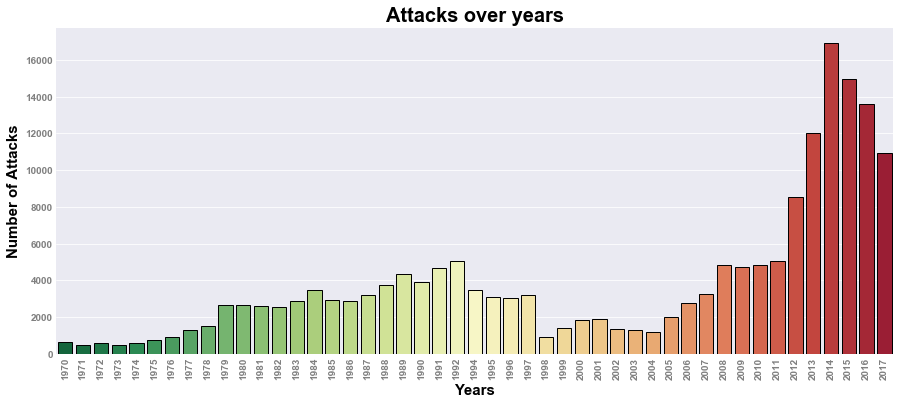

In [124]:
plt.figure(figsize=(15,6))
#plt.plot(years_in_database,attacks_per_year,,color='olive', linestyle ='-',marker='.',linewidth = '5')
sns.countplot('Year',data=gt,palette='RdYlGn_r',edgecolor='black')


plt.xlabel('Years',fontsize = 15,weight   = 'bold',color = 'black')
plt.ylabel('Number of Attacks',fontsize = 15,weight   = 'bold',color = 'black')

plt.title('Attacks over years',fontsize = 20,weight   = 'extra bold', color    = 'black')
plt.yticks(rotation = 0, weight   = 'bold', fontsize = 10, color   = 'grey')
plt.xticks(weight   = 'bold', fontsize = 10,color = 'grey',rotation=90)


#clear problem in case of 1993 can be observed

In [125]:
gt.loc[gt.Year == 1993, :].shape[0] # values for 1993 are missing

0

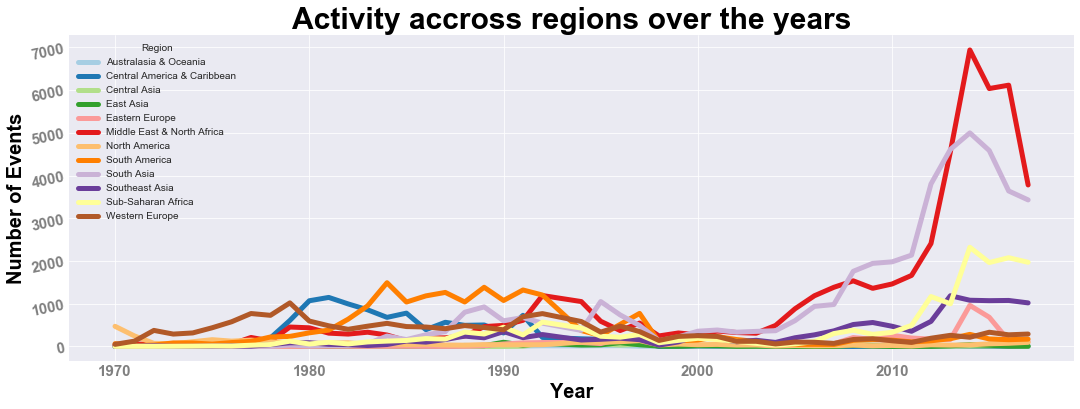

In [126]:
# Lets examine a region-wise distribution of attacks over the years

# plt.figure(figsize=(18,6))

qualitative_colors = sns.color_palette("Paired", 15)


tr = pd.crosstab(gt.Year, gt.Region)
tr.plot(color=qualitative_colors, lw = 5)

plt.title('Activity accross regions over the years',
          fontsize  = 30,
          weight    = 'extra bold',
          color     = 'black')

plt.xlabel('Year',              
           fontsize = 20,
           weight   = 'bold',
           color    = 'black')
plt.ylabel('Number of Events',              
           fontsize = 20,
           weight   = 'bold',
           color    = 'black')

plt.yticks(rotation = 12, 
           weight   = 'bold', 
           fontsize = 15,
           color    = 'grey')
plt.xticks(weight   = 'bold', 
           fontsize = 15,
           color    = 'grey')

fig=plt.gcf()
fig.set_size_inches(18,6)
plt.show()



In [127]:
#making a cumulative breakdown of the attacks by region

regions = gt.Region.value_counts()



In [128]:
ro = regions[regions > 1000] #to avoid any overlaps in our pie chart

In [129]:
idx = ro.index.values
idx[-1] = 'East Asia / Central Asia / Australasia & Oceania'
ro.index = idx

In [130]:
print(len(ro.index))
# Generating 9 explode values at evenly spaced intervals:
explode = np.arange(.06, 0, -.006)
explode_2 = (.04,0,0,0,0,0,0,0,0,)
print(len(explode))
print(len(explode_2))

9
10
9


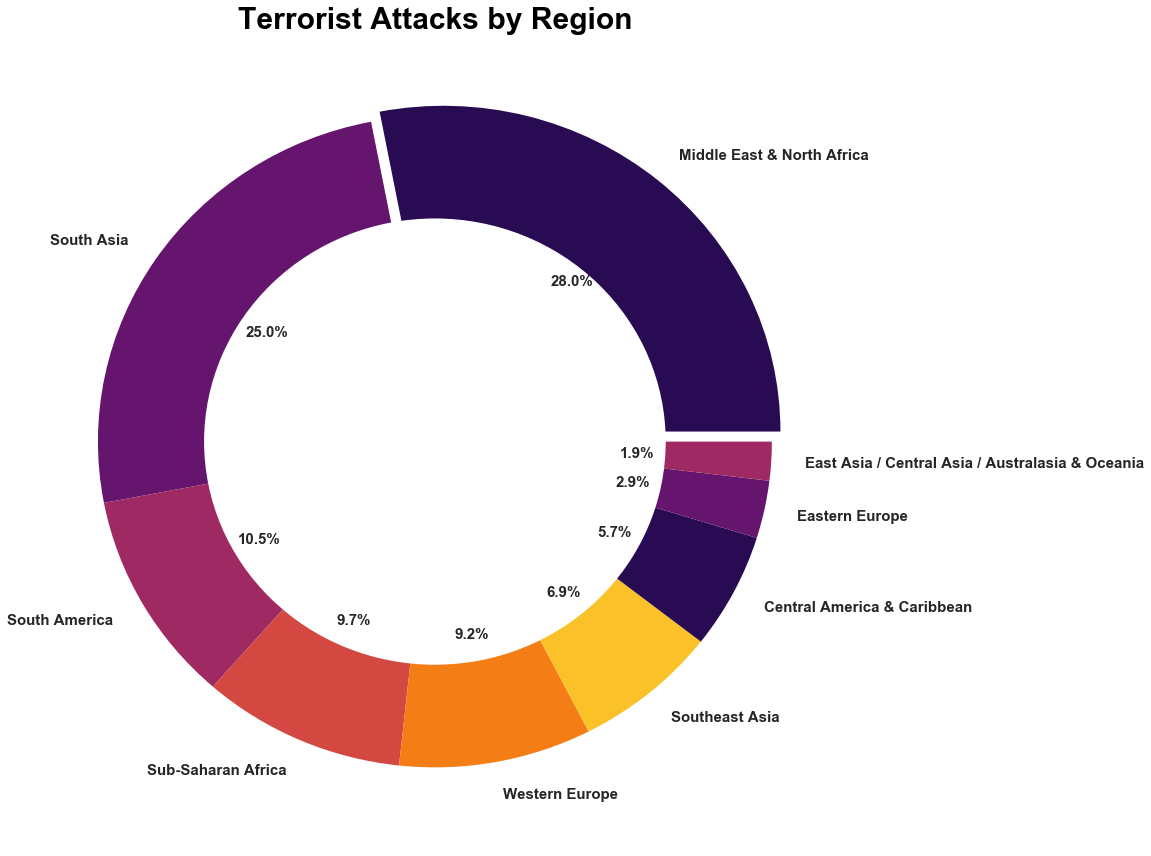

In [162]:
sns.set_palette('inferno')

plt.figure(figsize=(12, 12))
plt.pie(ro,
        labels     = ro.index,
        explode    = (.04,0,0,0,0,0,0,0,0),
        autopct    = '%1.1f%%',
        shadow     = False,
        textprops = {'fontsize': 15, 'weight':'bold'})
plt.title('Terrorist Attacks by Region', 
          fontsize  = 30,
          weight    = 'extra bold',
          color     = 'black')

# donut chart
centre_circle = plt.Circle((0,0),0.685,fc='white')

plt.gcf().gca().add_artist(centre_circle)
plt.tight_layout()


In [132]:
#add another dimension (attack types) to our regional breakdown

gt.AttackType.value_counts().index

Index(['Bombing/Explosion', 'Armed Assault', 'Assassination',
       'Hostage Taking (Kidnapping)', 'Facility/Infrastructure Attack',
       'Unknown', 'Unarmed Assault', 'Hostage Taking (Barricade Incident)',
       'Hijacking'],
      dtype='object')

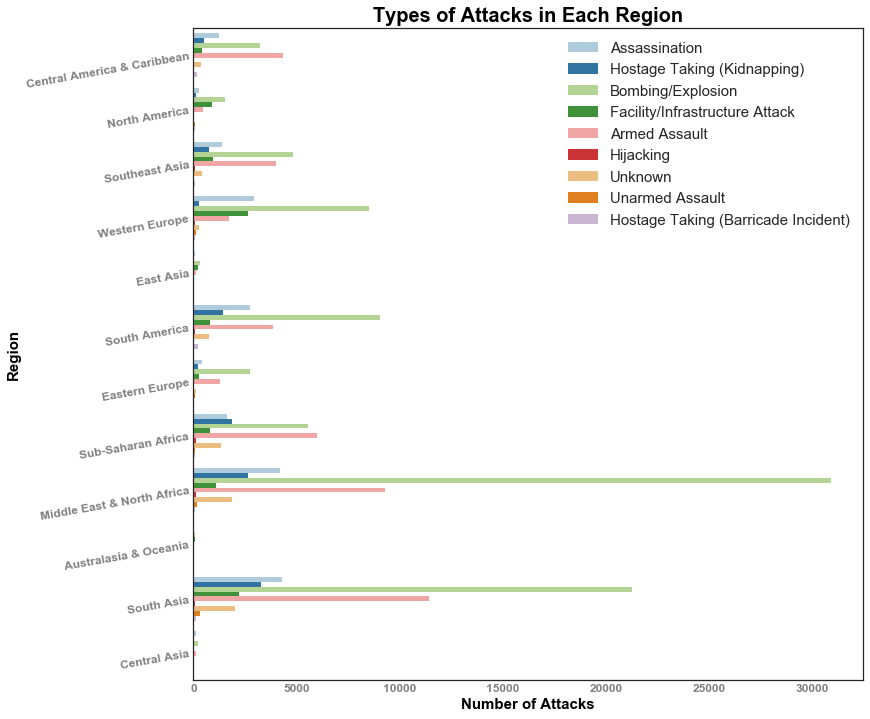

In [133]:
sns.set_style('white')
plt.figure(figsize=(12, 12))
sns.countplot(y='Region', 
              data=gt, 
              hue='AttackType', 
              palette=qualitative_colors)
plt.title('Types of Attacks in Each Region', 
          fontsize  = 20,
          weight    = 'extra bold',
          color     = 'black')
plt.xlabel('Number of Attacks',              
           fontsize = 15,
           weight   = 'bold',
           color    = 'black')
plt.ylabel('Region',              
           fontsize = 15,
           weight   = 'bold',
           color    = 'black')
plt.yticks(rotation = 10, 
           weight   = 'bold', 
           fontsize = 12,
           color    = 'grey')
plt.xticks(weight   = 'bold', 
           fontsize = 12,
           color    = 'grey')
plt.legend(loc =0, prop={'size': 15})


#bombing explosions are common accross most regions

In [134]:
gt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Data columns (total 18 columns):
Year           181691 non-null int64
Month          181691 non-null int64
Day            181691 non-null int64
Country        181691 non-null object
Region         181691 non-null object
city           181257 non-null object
latitude       177135 non-null float64
longitude      177134 non-null float64
AttackType     181691 non-null object
Killed         171378 non-null float64
Wounded        165380 non-null float64
Target         181055 non-null object
Summary        115562 non-null object
Group          181691 non-null object
Target_type    181691 non-null object
Weapon_type    181691 non-null object
Motive         50561 non-null object
casualties     164817 non-null float64
dtypes: float64(5), int64(3), object(10)
memory usage: 25.0+ MB


(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000.]),
 <a list of 9 Text xticklabel objects>)

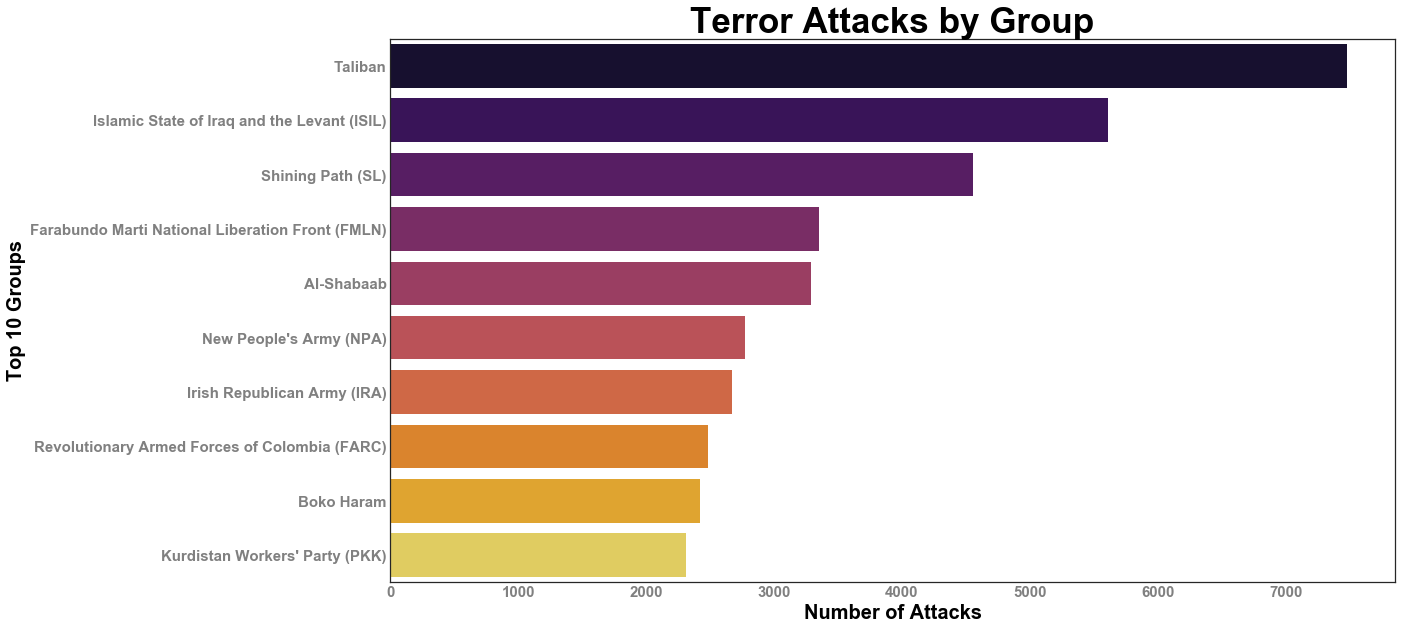

In [135]:

#lets examine the people behind these attacks


plt.figure(figsize=(18,10))
_ = sns.barplot(gt['Group'].value_counts()[1:11].values,
                 gt['Group'].value_counts()[1:11].index,
                 palette=('inferno'))
_.set_xlabel('Number of Attacks',
              fontsize = 20,
              weight   = 'bold',
              color    = 'black')
_.set_ylabel('Top 10 Groups',
              fontsize = 20,
              weight   = 'bold',
              color    = 'black')
plt.title('Terror Attacks by Group',
             fontsize = 35,
             weight   = 'extra bold',
             color    = 'black')
plt.yticks(weight   = 'extra bold', 
           fontsize = 15,
           color    = 'grey')
plt.xticks(weight   = 'bold', 
           fontsize = 15,
           color    = 'grey')

#the Taliban and ISIS (aka ISIL) are major menaces

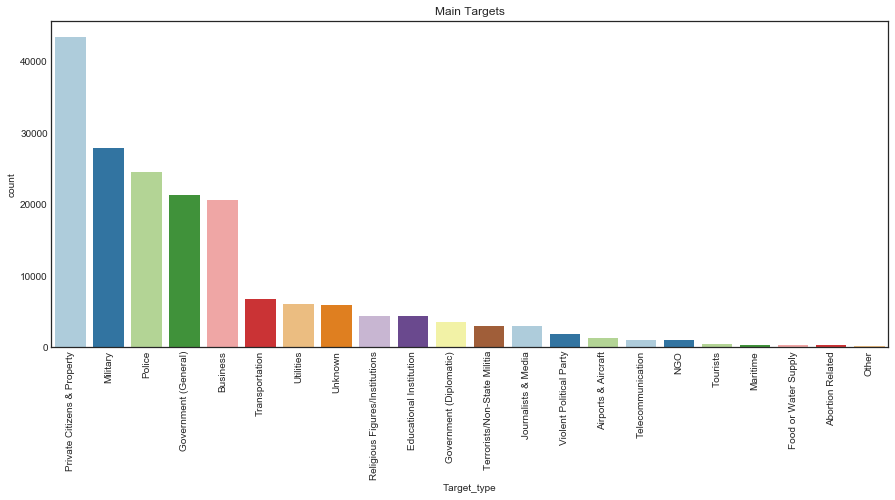

In [136]:
#lets see the main targets of these groups


plt.subplots(figsize=(15,6))
sns.countplot(gt['Target_type'],palette=qualitative_colors,order=gt['Target_type'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Main Targets')
plt.show()

#These groups majorly target common Public and properties

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


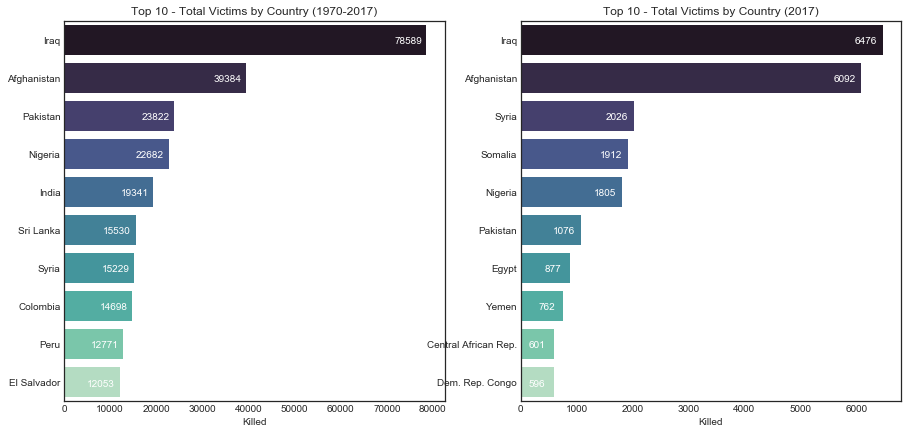

In [137]:
country_victims = gt.groupby(by='Country', as_index=False).sum().sort_values(by='Killed', 
                                                                      ascending=False).loc[:, ['Country', 
                                                                                               'Killed']]
country_victims = country_victims.iloc[:10, :]

terr_data_2017 = gt.query('Year == 2017')
country_victims_2017 = terr_data_2017.groupby(by='Country', as_index=False).sum().sort_values(by='Killed', 
                                                                      ascending=False).loc[:, ['Country', 
                                                                                               'Killed']]
country_victims_2017 = country_victims_2017.iloc[:10, :]
country_victims_2017['Country'][16] = 'Central African Rep.'
country_victims_2017['Country'][22] = 'Dem. Rep. Congo'

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

sns.barplot(x='Killed', y='Country', data=country_victims, ci=None,
                 palette='mako', ax=axs[0])
sns.barplot(x='Killed', y='Country', data=country_victims_2017, ci=None,
                 palette='mako', ax=axs[1])

axs[0].set_title('Top 10 - Total Victims by Country (1970-2017)')
axs[1].set_title('Top 10 - Total Victims by Country (2017)')
axs[0].set_ylabel('')
axs[1].set_ylabel('')

for p in axs[0].patches:
    width = p.get_width()
    axs[0].text(width-4000, p.get_y() + p.get_height() / 2. + 0.10, '{}'.format(int(width)), 
            ha="center", color='white')

for p in axs[1].patches:
    width = p.get_width()
    axs[1].text(width-300, p.get_y() + p.get_height() / 2. + 0.10, '{}'.format(int(width)), 
            ha="center", color='white')

plt.show()

# Part 2: Bayesian Inference

Terror attacks are a ripe area of research for Bayesian inference. Given their infrequency, it is (thankfully) difficult for us to assume a high number of samples that approach some normal distribution.

I'm going to be comparing the deadliness of Taliban attacks and ISIL attacks using Bayesian inference. We want to know if the deadliness of one differs in a significant way than the other.

##Looking at the deadliness of the Taliban compared to ISIL and see which one is worse

In [138]:
 # First making a deadliness metric based off numbers of killed,wounded and method of attack

In [139]:
gt_copy = gt.copy()
gt_copy.Killed.fillna(0, inplace=True)
gt_copy.Killed.isnull().sum()

0

In [140]:
gt_copy.Wounded.fillna(0, inplace=True)
gt_copy.Wounded.isnull().sum()

0

In [141]:
gt_copy['casualties'] = gt_copy['Killed'] + gt_copy['Wounded']
gt_copy.casualties.isnull().sum()

0

In [142]:

gt_copy['deadliness'] = gt_copy['Killed'] / gt_copy['casualties']
gt_copy.deadliness.isnull().sum()

73900

In [143]:
gt_copy.loc[gt_copy.deadliness.isnull(), ['Wounded', 'Killed', 'casualties', 'deadliness']]

,Wounded,Killed,casualties,deadliness
1,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,NaN
6,0.0,0.0,0.0,NaN
7,0.0,0.0,0.0,NaN
8,0.0,0.0,0.0,NaN
9,0.0,0.0,0.0,NaN
10,0.0,0.0,0.0,NaN
11,0.0,0.0,0.0,NaN


In [144]:
gt_copy.deadliness.fillna(0, inplace=True)
gt_copy.deadliness.isnull().sum()

0

In [145]:
gt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Data columns (total 18 columns):
Year           181691 non-null int64
Month          181691 non-null int64
Day            181691 non-null int64
Country        181691 non-null object
Region         181691 non-null object
city           181257 non-null object
latitude       177135 non-null float64
longitude      177134 non-null float64
AttackType     181691 non-null object
Killed         171378 non-null float64
Wounded        165380 non-null float64
Target         181055 non-null object
Summary        115562 non-null object
Group          181691 non-null object
Target_type    181691 non-null object
Weapon_type    181691 non-null object
Motive         50561 non-null object
casualties     164817 non-null float64
dtypes: float64(5), int64(3), object(10)
memory usage: 25.0+ MB


In [146]:
taliban_condensed = gt_copy.loc[gt_copy.Group == 'Taliban', ['Year', 'Month', 'Day','AttackType', 'latitude', 'longitude', 'Killed', 'Wounded', 'casualties', 'deadliness']]

isil_condensed = gt_copy.loc[gt_copy.Group == 'Islamic State of Iraq and the Levant (ISIL)', ['Year', 'Month', 'Day','AttackType', 'latitude', 'longitude', 'Killed', 'Wounded', 'casualties', 'deadliness']]

In [ ]:
# Building out model with pyMC3 to estimate the difference in deadliness between the Taliban and ISIL

In [ ]:
taliban_deadliness = taliban_condensed.deadliness.values
isil_deadliness = isil_condensed.deadliness.values

print (taliban_deadliness.mean(), isil_deadliness.mean())

In [ ]:
prior_mean = gt_copy.deadliness.mean()
prior_std = gt_copy.deadliness.std()
print(prior_mean, prior_std)

In [ ]:
with pm.Model() as model:
    
    taliban_mean = pm.Normal('taliban_mean', prior_mean, sd=0.5)
    isil_mean = pm.Normal('isil_mean', prior_mean, sd=0.5)
    
    taliban_std = pm.Gamma('taliban_std', mu=prior_std, sd=0.5)
    isil_std = pm.Gamma('isil_std', mu=prior_std, sd=0.5)
    
    taliban_rating = pm.Normal('taliban_rating', mu=taliban_mean, sd=taliban_std, observed=taliban_deadliness)
    isil_rating = pm.Normal('isil_rating', mu=isil_mean, sd=isil_std, observed=isil_deadliness)
    
    mean_delta = pm.Deterministic('mean_delta', taliban_mean - isil_mean)
    std_delta = pm.Deterministic('std_delta', taliban_std - isil_std)
    effect_size = pm.Deterministic('effect_size', mean_delta / np.sqrt((taliban_std**2 + isil_std**2)/2.))

In [119]:
with model:
    step = pm.NUTS()
    start = pm.find_MAP()
    trace = pm.sample(50000, start=start, step=step, njobs=4)

/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -6,758.6, ||grad|| = 0.0017914: 100%|██████████| 12/12 [00:00<00:00, 1269.56it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [isil_std, taliban_std, isil_mean, taliban_mean]
Sampling 4 chains:  59%|█████▉    | 119943/202000 [01:23<00:57, 1428.80draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c23a1e9b0>,
      dtype=object)

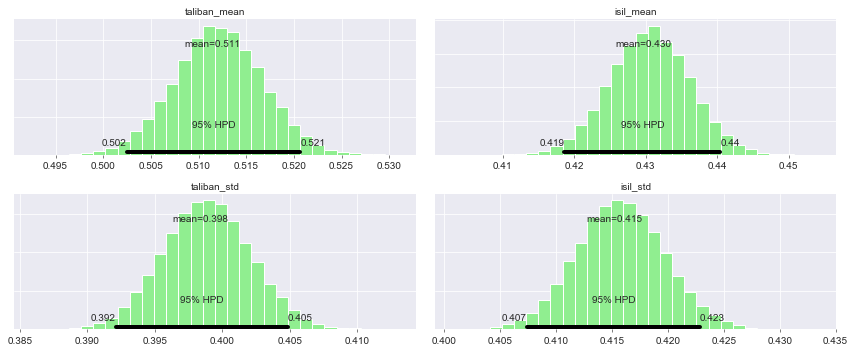

In [120]:
pm.plot_posterior(trace[5000::3],
                  varnames=['taliban_mean', 'isil_mean',
                            'taliban_std', 'isil_std'],
                  color='lightgreen')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c355bad68>,
      dtype=object)

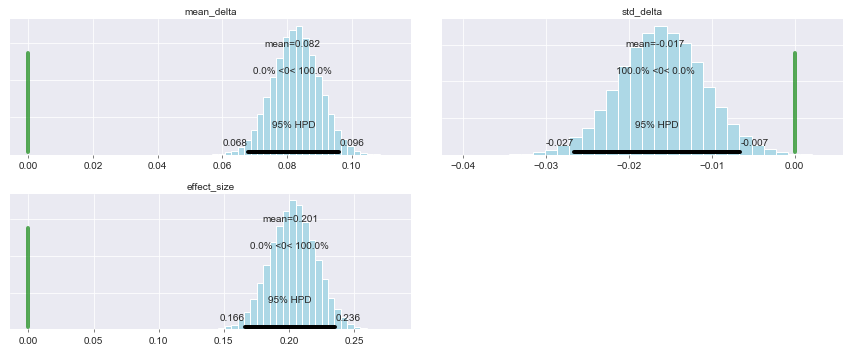

In [121]:
pm.plot_posterior(trace[5000::3],
                  varnames=['mean_delta','std_delta','effect_size'],
                  color='lightblue', ref_val=0)


## Analysis:

Based on the above model, we can see that Taliban attacks overall are about 10% deadlier than ISIL attacks. Further evidence of this can be seen looking at the mean_delta graph. Since the mean_delta is about 0.10 away from 0, we can conclude with 95% confidence that there is a real difference between the two populations.

# For reference:

This is looking at an all time view of attacks, which may or may not be the most accurate with regards to current relevancy. The Taliban have been active for a much longer time period than ISIL, so a good additional next step would be to break these (or other groups to compare) into a narrower time frame.

# Part 3: 1993 imputation

The year 1993 is missing from the dataset! Given there is a wealth of information across different types of attacks, we will focus analysis on bombings (category 3, as per the codebook).

#Once we've created a methodology and imputed the number of bombings in 1993, we'll apply the methodology to the other attack categories.

In [147]:
gt1 = pd.read_csv('globalterrorismdb_0718dist.csv', encoding='ISO-8859-1',low_memory=False)
bombings_gt1 = gt1.loc[gt1.attacktype1 == 3, :]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 <a list of 47 Text xticklabel objects>)

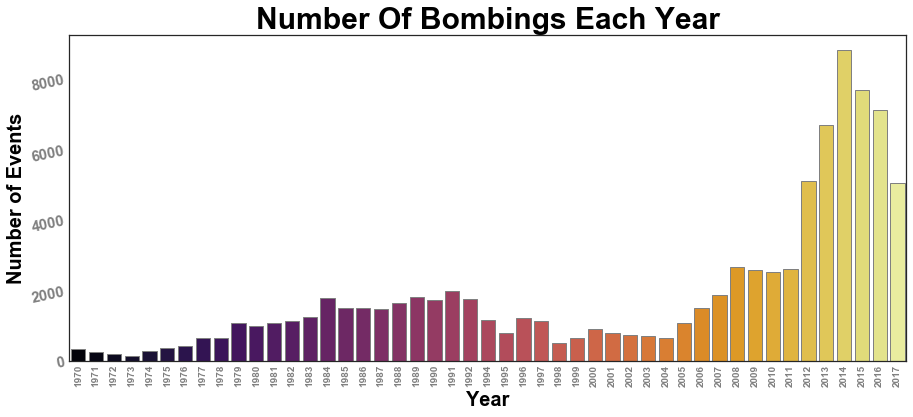

In [156]:
plt.subplots(figsize=(15,6))
sns.countplot(bombings_gt1.iyear,
              palette='inferno',
              edgecolor='grey')
plt.xticks(rotation=90)
plt.title('Number Of Bombings Each Year', 
          fontsize  = 30,
          weight    = 'extra bold',
          color     = 'black')
plt.xlabel('Year',              
           fontsize = 20,
           weight   = 'bold',
           color    = 'black')
plt.ylabel('Number of Events',              
           fontsize = 20,
           weight   = 'bold',
           color    = 'black')
plt.yticks(rotation = 12, 
           weight   = 'bold', 
           fontsize = 15,
           color    = 'grey')
plt.xticks(weight   = 'bold', 
           fontsize = 10,
           color    = 'grey')



From http://start.umd.edu/gtd/downloads/Codebook.pdf the total number of attacks in 1993 
(based on Appendix II is •4954•

As a basic look, I'll take the proportion of bombings compared to total attacks in 1990,1991,1992,1994,1995 and 1996 and apply that proportion to 4954 (which seems like a reasonable estimate based on my graph of total attacks over the years).

In [149]:
bomb_prop_90 = gt1[gt1.iyear == 1990].attacktype1.value_counts(normalize=True)[3]
bomb_prop_91 = gt1[gt1.iyear == 1991].attacktype1.value_counts(normalize=True)[3]
bomb_prop_92 = gt1[gt1.iyear == 1992].attacktype1.value_counts(normalize=True)[3]
bomb_prop_94 = gt1[gt1.iyear == 1994].attacktype1.value_counts(normalize=True)[3]
bomb_prop_95 = gt1[gt1.iyear == 1995].attacktype1.value_counts(normalize=True)[3]
bomb_prop_96 = gt1[gt1.iyear == 1996].attacktype1.value_counts(normalize=True)[3]

bomb_prop_93 = (bomb_prop_90 + bomb_prop_91 + bomb_prop_92 + bomb_prop_94 + bomb_prop_95 + bomb_prop_96) / 6
bomb_prop_93

0.3669270071675837

In [150]:
print('I estimate there were around:', round(bomb_prop_93 * 4954), 'bombings/explosions in 1993.')


I estimate there were around: 1818.0 bombings/explosions in 1993.


The above number seems like a realistic estimate for the total number of bombings based on what we see in the above graph.

In [151]:
attack_types_list = list(gt1.attacktype1_txt.unique())

In [158]:
est_no= []
for category in attack_types_list:
    cat_prop_90 = gt1[gt1.iyear == 1990].attacktype1_txt.value_counts(normalize=True)[category]
    cat_prop_91 = gt1[gt1.iyear == 1991].attacktype1_txt.value_counts(normalize=True)[category]
    cat_prop_92 = gt1[gt1.iyear == 1992].attacktype1_txt.value_counts(normalize=True)[category]
    cat_prop_94 = gt1[gt1.iyear == 1994].attacktype1_txt.value_counts(normalize=True)[category]
    cat_prop_95 = gt1[gt1.iyear == 1995].attacktype1_txt.value_counts(normalize=True)[category]
    cat_prop_96 = gt1[gt1.iyear == 1996].attacktype1_txt.value_counts(normalize=True)[category]
    
    cat_prop_93 = (cat_prop_90+cat_prop_91+cat_prop_92+cat_prop_94 + cat_prop_95+cat_prop_96) / 6
    
    
    est_number = round(cat_prop_93 * 4954)
    est_no.append(est_number)
estimated_numbers

[1005.0, 223.0, 1818.0, 362.0, 1192.0, 33.0, 234.0, 61.0, 26.0]

In [160]:
sum(est_no)

4954.0

In [161]:
est_1993 = dict(zip(attack_types_list, est_no))
est_1993

{'Assassination': 1005.0,
 'Hostage Taking (Kidnapping)': 223.0,
 'Bombing/Explosion': 1818.0,
 'Facility/Infrastructure Attack': 362.0,
 'Armed Assault': 1192.0,
 'Hijacking': 33.0,
 'Unknown': 234.0,
 'Unarmed Assault': 61.0,
 'Hostage Taking (Barricade Incident)': 26.0}

I think these numbers are fairly reasonable. Although the data isn't perfectly recorded in the codebook, the 4954 number represents the best efforts from those in charge of maintaining the dataset. For the most part, we can see from our attacks by year graph that up until 2010, there were not many dramatic changes in trends of overall attacks. 

In the future, I'd like to explore more sophisticated approaches for imputing the 1993 data.KNN could be a good algorithm for this task

